# AFM 
* Attentional Factorization Machines
* https://arxiv.org/pdf/1708.04617.pdf 

## 1. Load Data

In [1]:
import os

os.chdir("/content/drive/My Drive/tobigs_recommend/Phase 1. Data Collection & Preprocessing/1. Data")

In [2]:
import numpy as np
import pandas as pd

In [3]:
df_review = pd.read_excel("JS_10_data_review.xlsx")
df_place = pd.read_excel("JS_10_data_places_v2.xlsx")

In [4]:
df_review.head()

,id,rating,body,idno,place.id,place.name,photonum,createdDate
0,5ec7ec658160f100109a8368,4.5,NaN,4TXey,1150710065,스타벅스 보라매공원R점,0,2020-05-21 20:42:00
1,5d14eaa963951f37e4243fa5,5.0,none,awWC,1150710065,스타벅스 보라매공원R점,0,2019-06-28 01:11:03
2,5e69024bf896230011648a61,5.0,NaN,1Unzg,1150710065,스타벅스 보라매공원R점,0,2020-03-12 00:22:00
3,5e4f98b95543c700113e18e7,5.0,NaN,LRVl,1150710065,스타벅스 보라매공원R점,0,2020-02-16 17:06:00
4,5c8528bdf9e6b96d632ae302,5.0,2019.03.06\nHH,ESN1,1150710065,스타벅스 보라매공원R점,0,2019-03-11 00:08:48


In [5]:
df_place.head()

,Unnamed: 0,place.id,place.name,place.category,rating,review.count,is_fch,lat,lng,land.addr
0,0,11605455,가미분식,종합분식,4.217391,32,0,37.558661,126.945960,서울특별시 서대문구 대현동 54-1 무궁화상가아파트
1,1,10976694,유래회관,"육류,고기요리-일반",4.300000,27,0,37.566438,127.031591,서울특별시 성동구 홍익동 357 유래회관
2,2,11398664,대성갈비,"육류,고기요리-일반",4.216667,76,0,37.547073,127.044028,서울특별시 성동구 성수동1가 668-21
3,3,11663081,철길왕갈비살,"육류,고기요리-일반",4.400000,54,0,37.554546,126.931666,서울특별시 마포구 창전동 4-2
4,4,11677544,황소고집,"육류,고기요리-일반",4.379310,69,0,37.568593,126.986046,서울특별시 종로구 관철동 11-11


In [15]:
df_review = df_review.drop(["id", "body"], axis=1)
df_place = df_place.drop(["place.name", "Unnamed: 0", "lat", "lng", "land.addr"], axis=1)

In [17]:
df_place = df_place.rename(columns = {'rating' : 'place.meanrating'})

In [19]:
df_review.head()

,rating,idno,place.id,place.name,photonum,createdDate
0,4.5,4TXey,1150710065,스타벅스 보라매공원R점,0,2020-05-21 20:42:00
1,5.0,awWC,1150710065,스타벅스 보라매공원R점,0,2019-06-28 01:11:03
2,5.0,1Unzg,1150710065,스타벅스 보라매공원R점,0,2020-03-12 00:22:00
3,5.0,LRVl,1150710065,스타벅스 보라매공원R점,0,2020-02-16 17:06:00
4,5.0,ESN1,1150710065,스타벅스 보라매공원R점,0,2019-03-11 00:08:48


In [18]:
df_place.head()

,place.id,place.category,place.meanrating,review.count,is_fch
0,11605455,종합분식,4.217391,32,0
1,10976694,"육류,고기요리-일반",4.300000,27,0
2,11398664,"육류,고기요리-일반",4.216667,76,0
3,11663081,"육류,고기요리-일반",4.400000,54,0
4,11677544,"육류,고기요리-일반",4.379310,69,0


In [21]:
df = pd.merge(df_review, df_place[["place.id", "place.category", "place.meanrating", "review.count", "is_fch"]], 
              on="place.id", how="left")

In [22]:
df.head()

,rating,idno,place.id,place.name,photonum,createdDate,place.category,place.meanrating,review.count,is_fch
0,4.5,4TXey,1150710065,스타벅스 보라매공원R점,0,2020-05-21 20:42:00,스타벅스,4.590717,158,1
1,5.0,awWC,1150710065,스타벅스 보라매공원R점,0,2019-06-28 01:11:03,스타벅스,4.590717,158,1
2,5.0,1Unzg,1150710065,스타벅스 보라매공원R점,0,2020-03-12 00:22:00,스타벅스,4.590717,158,1
3,5.0,LRVl,1150710065,스타벅스 보라매공원R점,0,2020-02-16 17:06:00,스타벅스,4.590717,158,1
4,5.0,ESN1,1150710065,스타벅스 보라매공원R점,0,2019-03-11 00:08:48,스타벅스,4.590717,158,1


In [23]:
df.shape # user : idno , item : place.id

(415515, 10)

In [27]:
print(df["idno"].nunique(), df["place.id"].nunique())

65804 15176


In [30]:
import datetime 
import time 

In [36]:
type(df["createdDate"][0]) # timestamp to timestamp? 굳이 바꿀필요 없을 것 같기두 하고 ... 

pandas._libs.tslibs.timestamps.Timestamp

In [34]:
df["createdDate"] = df.apply(lambda x : time.mktime(datetime.datetime.strptime(x['createdDate'], '%Y-%m-%d %H:%M:%S').timetuple()), axis=1)

TypeError: ignored

In [32]:
df.head()

,rating,idno,place.id,place.name,photonum,createdDate,place.category,place.meanrating,review.count,is_fch
0,4.5,4TXey,1150710065,스타벅스 보라매공원R점,0,2020-05-21 20:42:00,스타벅스,4.590717,158,1
1,5.0,awWC,1150710065,스타벅스 보라매공원R점,0,2019-06-28 01:11:03,스타벅스,4.590717,158,1
2,5.0,1Unzg,1150710065,스타벅스 보라매공원R점,0,2020-03-12 00:22:00,스타벅스,4.590717,158,1
3,5.0,LRVl,1150710065,스타벅스 보라매공원R점,0,2020-02-16 17:06:00,스타벅스,4.590717,158,1
4,5.0,ESN1,1150710065,스타벅스 보라매공원R점,0,2019-03-11 00:08:48,스타벅스,4.590717,158,1


## 2. Import Module
* https://github.com/DeepCTR/DeepCTR 

In [24]:
pip install git+https://github.com/DeepCTR/DeepCTR 

  Cloning https://github.com/DeepCTR/DeepCTR to /tmp/pip-req-build-odd3col0
  Running command git clone -q https://github.com/DeepCTR/DeepCTR /tmp/pip-req-build-odd3col0
  Created wheel for deepctr: filename=deepctr-0.6.2-cp36-none-any.whl size=83204 sha256=e348b1104431204692c7166d5be213d5a53599b7967560b2467ccbb98f9c385f
  Stored in directory: /tmp/pip-ephem-wheel-cache-cno8bpi_/wheels/74/21/70/159294e001d38c153c0210fd6fea2e4b6a3fd6e04bcab327cd
Successfully built deepctr


In [60]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from deepctr.models import AFM
from deepctr.inputs import SparseFeat, DenseFeat, VarLenSparseFeat,get_feature_names
from math import sqrt

import datetime

In [28]:
df.head()

,rating,idno,place.id,place.name,photonum,createdDate,place.category,place.meanrating,review.count,is_fch
0,4.5,4TXey,1150710065,스타벅스 보라매공원R점,0,2020-05-21 20:42:00,스타벅스,4.590717,158,1
1,5.0,awWC,1150710065,스타벅스 보라매공원R점,0,2019-06-28 01:11:03,스타벅스,4.590717,158,1
2,5.0,1Unzg,1150710065,스타벅스 보라매공원R점,0,2020-03-12 00:22:00,스타벅스,4.590717,158,1
3,5.0,LRVl,1150710065,스타벅스 보라매공원R점,0,2020-02-16 17:06:00,스타벅스,4.590717,158,1
4,5.0,ESN1,1150710065,스타벅스 보라매공원R점,0,2019-03-11 00:08:48,스타벅스,4.590717,158,1


## 3. Data Preprocessing 
* 1. Sparse Feature : 범주형 (LabelEncoder)
* 2. Dense Feature : 연속형 (MinMaxScaler) 

In [45]:
type(df["idno"][0])

numpy.int64

In [44]:
df2 = df.copy()

In [46]:
df2.columns

Index(['rating', 'idno', 'place.id', 'place.name', 'photonum', 'createdDate',
       'place.category', 'place.meanrating', 'review.count', 'is_fch'],
      dtype='object')

In [50]:
for col in df2.columns: 
    print(col, type(df2[col][0]))

rating <class 'numpy.float64'>
idno <class 'numpy.int64'>
place.id <class 'numpy.int64'>
place.name <class 'str'>
photonum <class 'numpy.int64'>
createdDate <class 'pandas._libs.tslibs.timestamps.Timestamp'>
place.category <class 'str'>
place.meanrating <class 'numpy.float64'>
review.count <class 'numpy.int64'>
is_fch <class 'int'>


In [52]:
df["idno"] = df.apply(lambda x : df["idno"].astype(str))

In [54]:
df["place.id"] = df.apply(lambda x : df["place.id"].astype(str))
df["place.category"] = df.apply(lambda x : df["place.category"].astype(str))

In [55]:
for col in df.columns: 
    print(col, type(df[col][0]))

rating <class 'numpy.float64'>
idno <class 'numpy.int64'>
place.id <class 'str'>
place.name <class 'str'>
photonum <class 'numpy.int64'>
createdDate <class 'pandas._libs.tslibs.timestamps.Timestamp'>
place.category <class 'str'>
place.meanrating <class 'numpy.float64'>
review.count <class 'numpy.int64'>
is_fch <class 'int'>


In [57]:
sparse_features = ['idno', 'place.id', 'place.category']  # 'is_fch' 못넣었음 number가 아니라는데 뭔소리인즤 ㅎㅎㅎ;; 
target = ['rating']

In [58]:
# 1. Label Encoding 
for feat in sparse_features:
    lbe = LabelEncoder()
    df[feat] = lbe.fit_transform(df[feat])

In [62]:
# 2. SparseFeat으로 변환
fixlen_feature_columns = [SparseFeat(feat, df[feat].nunique()) for feat in sparse_features]

In [63]:
fixlen_feature_columns

[SparseFeat(name='idno', dimension=65804, use_hash=False, dtype='int32', embedding_name='idno', embedding=True),
 SparseFeat(name='place.id', dimension=15176, use_hash=False, dtype='int32', embedding_name='place.id', embedding=True),
 SparseFeat(name='place.category', dimension=735, use_hash=False, dtype='int32', embedding_name='place.category', embedding=True)]

In [66]:
# 3. DenseFeat : 이렇게 설정하면 shape에서 오류가 난다... 이렇게는 못쓸듯...? ㅠㅠ 
dense_features = ["photonum", "place.meanrating", "review.count"]
dense_feature_columns = [DenseFeat(feat, df[feat].nunique()) for feat in dense_features] # name, dimension 

In [67]:
dense_feature_columns

[DenseFeat(name='photonum', dimension=52, dtype='float32'),
 DenseFeat(name='place.meanrating', dimension=2544, dtype='float32'),
 DenseFeat(name='review.count', dimension=261, dtype='float32')]

In [93]:
# 3-1 : VarlenSparse ... 
continuous_features = ["photonum", "place.meanrating", "review.count"]
dense_feature_columns = [VarLenSparseFeat(feat, df[feat].nunique(), 415515) for feat in continuous_features]

In [94]:
all_features = fixlen_feature_columns + dense_feature_columns

In [95]:
all_features

[SparseFeat(name='idno', dimension=65804, use_hash=False, dtype='int32', embedding_name='idno', embedding=True),
 SparseFeat(name='place.id', dimension=15176, use_hash=False, dtype='int32', embedding_name='place.id', embedding=True),
 SparseFeat(name='place.category', dimension=735, use_hash=False, dtype='int32', embedding_name='place.category', embedding=True),
 VarLenSparseFeat(name='photonum', dimension=52, maxlen=415515, combiner='mean', use_hash=False, dtype='float32', embedding_name='photonum', embedding=True),
 VarLenSparseFeat(name='place.meanrating', dimension=2544, maxlen=415515, combiner='mean', use_hash=False, dtype='float32', embedding_name='place.meanrating', embedding=True),
 VarLenSparseFeat(name='review.count', dimension=261, maxlen=415515, combiner='mean', use_hash=False, dtype='float32', embedding_name='review.count', embedding=True)]

In [96]:
linear_feature_columns = all_features
dnn_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [97]:
feature_names

['idno',
 'place.id',
 'place.category',
 'photonum',
 'place.meanrating',
 'review.count']

## 4. Modeling 

In [98]:
# Generate input data for model
train, test = train_test_split(df, test_size=0.2)
train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

In [99]:
# dnn 에는 dense feature 안들어간다! (연속형 변수)
afm = AFM(linear_feature_columns, dnn_feature_columns, task='regression', afm_dropout=0.5)
afm.compile("adam", "mse", metrics=['mse'], )
afm.summary()

The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'afm_layer_1/projection_p:0' shape=(8, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'afm_layer_1/projection_p:0' shape=(8, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
photonum (InputLayer)           [(None, 415515)]     0                                            
__________________________________________________________________________________________________
place.meanrating (InputLayer)   [(None, 415515)]     0                                            
__________________________________________________________________________________________________
review.count (InputLayer)       [(None, 415515)]     0                                            
__________________________________________________________________________________________________
idno (InputLayer)               [(None, 1)]          0                                            
____________________________________________________________________________________________

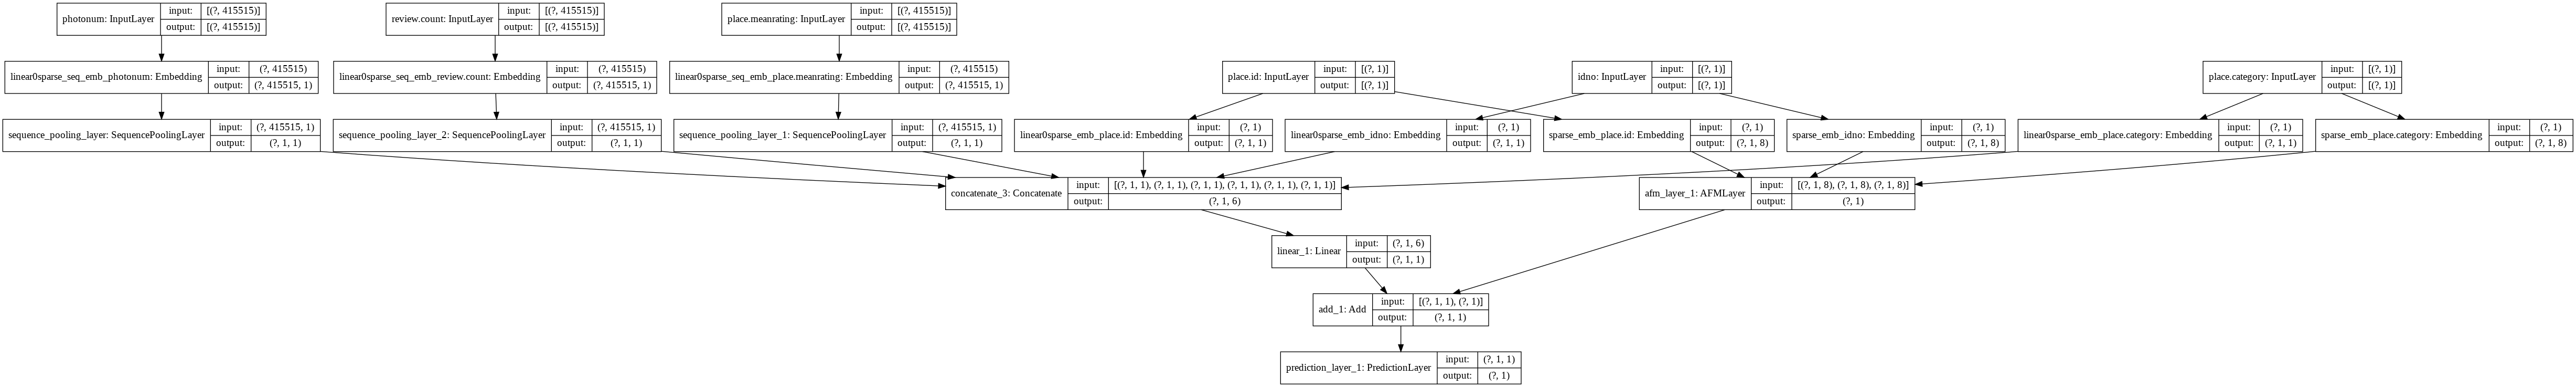

In [100]:
plot_model(afm, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [101]:
history = afm.fit(train_model_input, train[target].values, 
                  batch_size=256, epochs=3, verbose=2, validation_split=0.2, )

Epoch 1/3


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


InvalidArgumentError: ignored

In [ ]:
pred_ans = afm.predict(test_model_input, batch_size=256)
print("test MSE", round(mean_squared_error(test[target].values, pred_ans), 4)) # MSE 말고 다른 지표... 